# Test sets in depth

In the previous exercise, we looked at how to split our data into training and test sets to evaluate model performance.

We'll now repeat the last exercise, but this time we'll look at what happens when we split the data in different ways and ratios.

First, let's recall what's in our dataset:

In [4]:
import pandas
#!pip install statsmodels
#!wget https://raw.githubusercontent.com/MicrosoftDocs/mslearn-introduction-to-machine-learning/main/Data/dog-training.csv
#!wget https://raw.githubusercontent.com/MicrosoftDocs/mslearn-introduction-to-machine-learning/main/Data/dog-training-switzerland.csv
#!wget https://raw.githubusercontent.com/MicrosoftDocs/mslearn-introduction-to-machine-learning/main/graphing.py

url = "https://raw.githubusercontent.com/MicrosoftDocs/mslearn-introduction-to-machine-learning/main/Data/dog-training.csv"

data = pandas.read_csv(url, delimiter="\t")

print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (50, 5)


,month_old_when_trained,mean_rescues_per_year,age_last_year,weight_last_year,rescues_last_year
0,68,21.1,9,14.5,35
1,53,14.9,5,14.0,30
2,41,20.5,6,17.7,34
3,3,19.4,1,13.7,29
4,4,24.9,4,18.4,30


Let's take a quick look at what the distribution of our data looks like (remember that we were using `weight_last_year` to predict the value of `rescues_last_year`). 

No. observations: 50


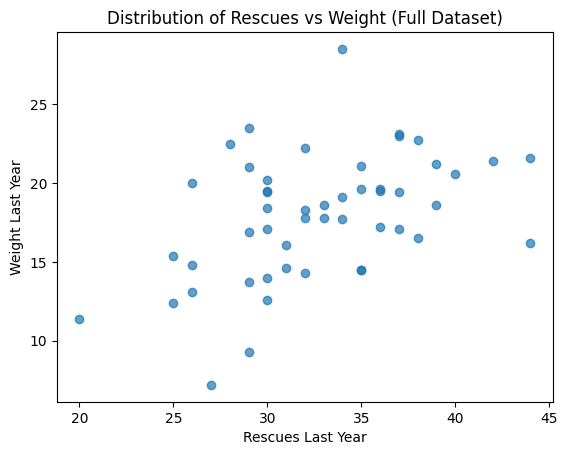

In [5]:
import matplotlib.pyplot as plt

# Obtain the label and feature from the original data
dataset = data[['rescues_last_year','weight_last_year']]

# Print the number of observations
print("No. observations:", dataset.shape[0])

# Scatter plot of the full (unsplit) dataset
plt.scatter(dataset['rescues_last_year'], dataset['weight_last_year'], alpha=0.7)

plt.xlabel("Rescues Last Year")
plt.ylabel("Weight Last Year")
plt.title("Distribution of Rescues vs Weight (Full Dataset)")
plt.show()

Notice we have 50 observations plotted (which corresponds to the number of samples in the dataset).

## Dataset split ratio comparison

We'll now split our dataset using different ratios to understand how these can affect our models.

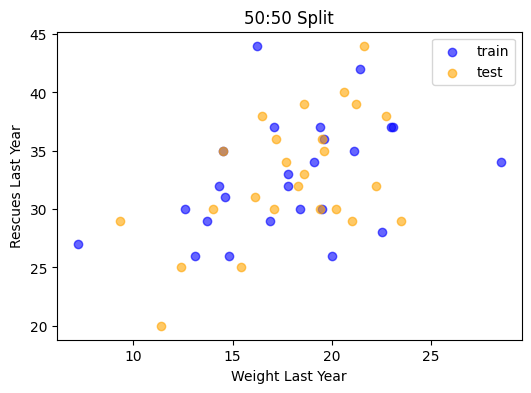

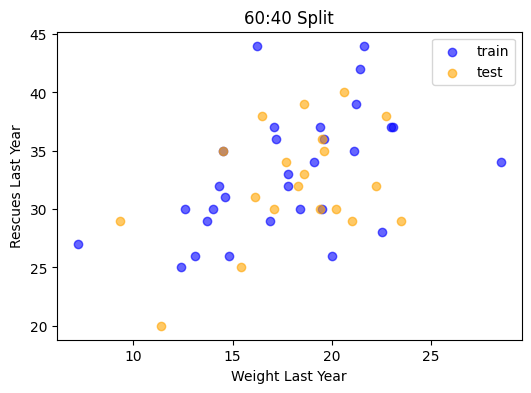

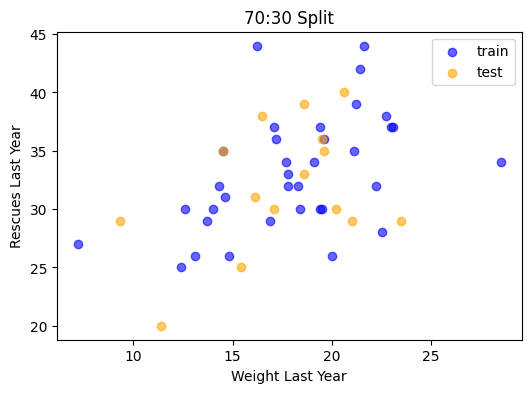

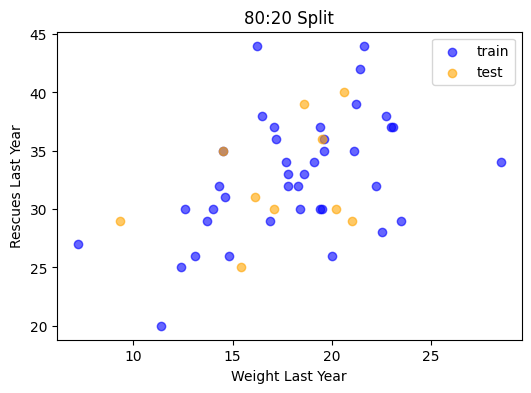

In [6]:
from sklearn.model_selection import train_test_split

# Split Dataset using different ratios 50:50, 60:40, 70:30, 80:20
train_5050, test_5050 = train_test_split(dataset, test_size=0.5, random_state=2)
train_6040, test_6040 = train_test_split(dataset, test_size=0.4, random_state=2)
train_7030, test_7030 = train_test_split(dataset, test_size=0.3, random_state=2)
train_8020, test_8020 = train_test_split(dataset, test_size=0.2, random_state=2)

# Add a column to each set to identify if a datapoint belongs to "train" or "test"
train_5050, test_5050 = train_5050.assign(Set="train"), test_5050.assign(Set="test")
train_6040, test_6040 = train_6040.assign(Set="train"), test_6040.assign(Set="test")
train_7030, test_7030 = train_7030.assign(Set="train"), test_7030.assign(Set="test")
train_8020, test_8020 = train_8020.assign(Set="train"), test_8020.assign(Set="test")

# Concatenate the "train" and "test" sets for each split so we can plot them on the same chart
df_5050 = pandas.concat([train_5050, test_5050], axis=0)
df_6040 = pandas.concat([train_6040, test_6040], axis=0)
df_7030 = pandas.concat([train_7030, test_7030], axis=0)
df_8020 = pandas.concat([train_8020, test_8020], axis=0)

# Function to plot each split
def plot_split(df, title):
    colors = {'train': 'blue', 'test': 'orange'}
    plt.figure(figsize=(6, 4))
    for label in df["Set"].unique():
        subset = df[df["Set"] == label]
        plt.scatter(subset["weight_last_year"], subset["rescues_last_year"],
                    label=label, alpha=0.6, c=colors[label])
    plt.xlabel("Weight Last Year")
    plt.ylabel("Rescues Last Year")
    plt.title(title)
    plt.legend()
    plt.show()

# Plot each distribution for comparison
plot_split(df_5050, "50:50 Split")
plot_split(df_6040, "60:40 Split")
plot_split(df_7030, "70:30 Split")
plot_split(df_8020, "80:20 Split")

Notice how the first splits leave us with relatively small _training_ datasets. On the 50:50 split, we have only 25 samples to train with.

On the other hand, the latter ones leave us much more data for training, but relatively little for testing. The 80:20 split leaves us with only 10 samples in the _test_ set!


Let's take a look at the distributions of _training_ data for each split:

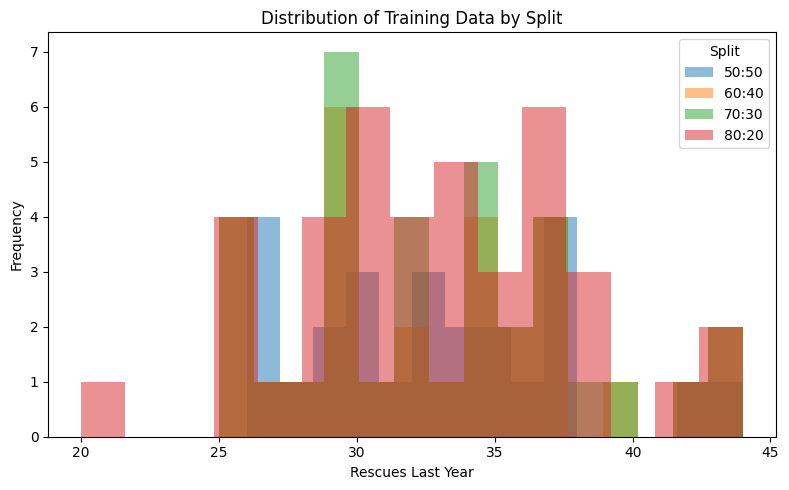

In [7]:
# Add a column for each "train" set that identifies the split used
train_8020 = train_8020.assign(Split="80:20")
train_7030 = train_7030.assign(Split="70:30")
train_6040 = train_6040.assign(Split="60:40")
train_5050 = train_5050.assign(Split="50:50")

# Concatenate training sets so we can plot them on the same chart
split_df = pandas.concat([train_5050, train_6040, train_7030, train_8020], axis=0)

# Plot a histogram of data distribution
plt.figure(figsize=(8, 5))
splits = split_df["Split"].unique()
for split in splits:
    subset = split_df[split_df["Split"] == split]
    plt.hist(subset["rescues_last_year"], bins=15, alpha=0.5, label=split)

plt.xlabel("Rescues Last Year")
plt.ylabel("Frequency")
plt.title("Distribution of Training Data by Split")
plt.legend(title="Split")
plt.tight_layout()
plt.show()

We can draw a couple of conclusions from the plot above:

1. The `train_test_split()` function we used does a fairly good job of keeping a fair distribution of data across different ratios. It attempts to keep different values represented in the same proportion.

2. When we use a `50:50` ratio, however, we have to leave so much data out of the _train_ set that some values aren't present anymore! (Can you spot where blue bars are missing?)

Point `2` is especially concerning, because if that data isn't available for training, our model can't learn from it, and therefore won't make accurate predictions. In other words, using a `50:50` split doesn't look like a good idea for this dataset.

## Fitting and evaluating models with different split ratios

Let's fit models using different splits, then see how they appear to perform:

In [8]:
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error as mse

def train_and_test_model(name, train, test):
    '''
    This method creates a model, trains it on the provided data, and assesses 
    it against the test data
    '''
    # This formula says that rescues_last_year is explained by weight_last_year
    formula = "rescues_last_year ~ weight_last_year"

    # Create and train a linear regression model using the training data
    model = smf.ols(formula = formula, data = train).fit()

    # Now evaluate the model (by calculating the Mean Squared Error) using the 
    # corresponding "test" set for that split
    correct_answers = test['rescues_last_year']
    predictions = model.predict(test['weight_last_year'])
    MSE = mse(correct_answers, predictions)
    print(name + ' MSE = %f ' % MSE)

    return model


# Train a model and test it for each kind of split
print("Mean Squared Error values (smaller is better)")
model_5050 = train_and_test_model("50:50", train_5050, test_5050)
model_6040 = train_and_test_model("60:40", train_6040, test_6040)
model_7030 = train_and_test_model("70:30", train_7030, test_7030)
model_8020 = train_and_test_model("80:20", train_8020, test_8020)

Mean Squared Error values (smaller is better)
50:50 MSE = 21.930788 
60:40 MSE = 19.834762 
70:30 MSE = 23.747817 
80:20 MSE = 18.441786 


The preceding code trains one model for each ratio, using the corresponding _train_ set for that ratio. It then calculates the MSE (Mean Squared Error) for each model, using its corresponding _test_ set.

The results seem mixed. The `80:20` ratio was best, but there's no clear pattern as to whether growing or shrinking the training set is helpful.

Two things influence our results. First, the larger the _test_ set, the more we can trust the test results. Secondly, models usually will train better with larger training sets. 

These influences are at odds with one another, and how influential they are is exaggerated here because our dataset it very small. In this particular situation, it's hard to assess whether the `60:40` split is truly better than the `70:30` split, for example. This is because the `70:30 split` might just give the appearance of being worse because it was tested against a less-representative (smaller) test set.

## Model evaluation

Let's take a look now at what happens when these models are used against a much larger dataset on which it wasn't trained or tested. This can happen in the real world because we choose to hold back data in the beginning, or simply because we collect data after training our model. In our current scenario, this is new data given to us by our avalanche-rescue charity's European arm.


The Swiss dataset contains 500 samples


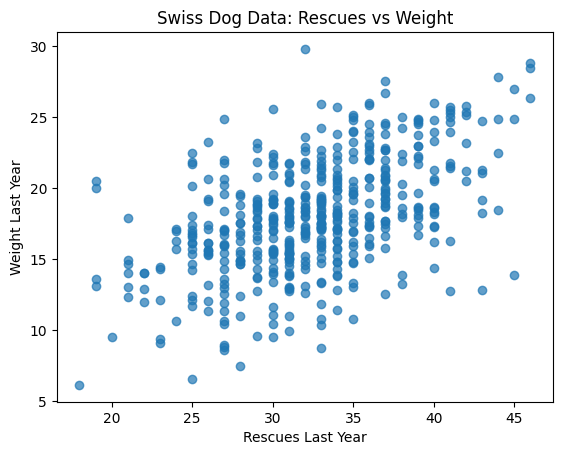

In [10]:
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error as mse

# Load some dog statistics from our charity's European arm
url = "https://raw.githubusercontent.com/MicrosoftDocs/mslearn-introduction-to-machine-learning/main/Data/dog-training-switzerland.csv"
swiss_data = pandas.read_csv(url, delimiter="\t")

# Show show information about the data
print(f"The Swiss dataset contains {swiss_data.shape[0]} samples")

plt.scatter(swiss_data['rescues_last_year'], swiss_data['weight_last_year'], alpha=0.7)

plt.xlabel("Rescues Last Year")
plt.ylabel("Weight Last Year")
plt.title("Swiss Dog Data: Rescues vs Weight")
plt.show()

This is clearly a much larger sample of data. Let's see how our models perform. Note that we aren't retraining the models here; we're simply using them to make predictions on a new dataset to assess how well they perform.

In [11]:
# Test our models against the swiss data
features = swiss_data['weight_last_year']
correct_answers = swiss_data['rescues_last_year']

# We will now assess our models. Notice we're not training them again.
# We are simply testing them against some new data 

# Assess the model trained on a 50:50 split
predictions = model_5050.predict(features)
MSE = mse(correct_answers, predictions)
print('50:50 MSE = %f ' % MSE)

# Assess the model trained on a 60:40 split
predictions = model_6040.predict(features)
MSE = mse(correct_answers, predictions)
print('60:40 MSE = %f ' % MSE)

# Assess the model trained on a 70:30 split
predictions = model_7030.predict(features)
MSE = mse(correct_answers, predictions)
print('70:30 MSE = %f ' % MSE)

# Assess the model trained on a 80:20 split
predictions = model_8020.predict(features)
MSE = mse(correct_answers, predictions)
print('80:20 MSE = %f ' % MSE)

50:50 MSE = 20.903325 
60:40 MSE = 20.520190 
70:30 MSE = 20.355991 
80:20 MSE = 20.061225 


With this larger dataset, the model using to `80:20` split yielded the lowest error, and thus the best performance. There's also a clear pattern: the larger the training dataset, the better the model could perform after training.

Together, this shows that we should try and evaluate different train/test splits when building machine learning models, and that _generally_ splits that favor the _train_ set with more data will yield better results. 
 
## Summary

In this exercise, you learned the following concepts:

 - You can use different *ratios* when splitting your dataset into *train* and *test* sets.
 - Different ratios yield different distributions of variables in the resulting *train* and *test* sets.
 - When the train:test ratios are close, you're possibly leaving a lot of data out of the __training__ set, and that can have a negative impact on your model's performance.
 - When building models, it's important to test them using different train/test splits. Simply assigning more data to the *train* set doesn't always guarantee the best results.
